In [35]:
# @title Some standard imports
# Standard library imports
import json
import os
import random
from typing import List, Tuple, Union

# Third-party imports
import gdown
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from sklearn.model_selection import train_test_split

# Colab specific imports

# Constants
device = "cuda" if torch.cuda.is_available() else "cpu"
json_file = "kq1.json"

In [36]:
# @title
def open_file(file_path: str) -> Union[dict, list, None]:
    """
    Opens and reads the content of a JSON or YAML file.

    Parameters:
    file_path (str): The path to the file.

    Returns:
    Union[dict, list, None]: The content of the file parsed to a dictionary or a list,
                             or None if an error occurs.
    """
    with open(file_path, "r") as file:
        if file_path.endswith(".json"):
            return json.load(file)
        elif file_path.endswith(".yaml") or file_path.endswith(".yml"):
            return yaml.safe_load(file)
        else:
            raise ValueError(f"Unsupported file format: {file_path}")


# Usage:
annotations = open_file(json_file)

In [37]:
# @title Expand this cell to see how the `AnimalPoseEstimationDataset` is implemented
from super_gradients.common.decorators.factory_decorator import resolve_param
from super_gradients.common.factories.transforms_factory import TransformsFactory
from super_gradients.training.transforms.keypoint_transforms import AbstractKeypointTransform
from super_gradients.training.samples import PoseEstimationSample

from super_gradients.training.utils.distributed_training_utils import wait_for_the_master
from super_gradients.common.environment.ddp_utils import get_local_rank
from super_gradients.training.datasets.pose_estimation_datasets.abstract_pose_estimation_dataset import AbstractPoseEstimationDataset

from super_gradients.training.datasets.pose_estimation_datasets import YoloNASPoseCollateFN
class BillPoseEstimationDataset(AbstractPoseEstimationDataset):
    """
    Dataset class for training pose estimation models on Animal Pose dataset.
    """

    @classmethod
    def split_bill_pose_dataset(cls, annotation_file: str, train_annotation_file: str, val_annotation_file: str, val_fraction: float):

        # Open and load the entire annotations JSON file
        with open(annotation_file, "r") as f:
            annotation = json.load(f)

        # Extract image IDs from the annotations
        image_ids = list(annotation["images"].keys())

        # Extract labels for each image to be used for stratified splitting
        # (ensures a balanced class distribution in train and validation sets)
        labels = [[ann["category_id"] for ann in annotation["annotations"] if ann["image_id"] == image_id] for image_id in image_ids]
        labels = [label[0] if len(label) else -1 for label in labels]  # Choose the first label if present, else assign -1

        # Split the dataset into training and validation sets
        train_ids, val_ids = train_test_split(image_ids, test_size=val_fraction, random_state=42, stratify=labels)

        # Prepare annotations dictionary for training set
        train_annotations = {
            "categories": annotation["categories"],
            "images": dict((image_id, annotation["images"][image_id]) for image_id in train_ids),
            "annotations": [ann for ann in annotation["annotations"] if str(ann["image_id"]) in train_ids],
        }

        # Prepare annotations dictionary for validation set
        val_annotations = {
            "categories": annotation["categories"],
            "images": dict((image_id, annotation["images"][image_id]) for image_id in val_ids),
            "annotations": [ann for ann in annotation["annotations"] if str(ann["image_id"]) in val_ids],
        }

        # Save the annotations for the training set to a JSON file
        with open(train_annotation_file, "w") as f:
            json.dump(train_annotations, f)
            print("Train annotations saved to", train_annotation_file)
            print("Train images:", len(train_ids))
            print("Train annotations:", len(train_annotations["annotations"]))

        # Save the annotations for the validation set to a JSON file
        with open(val_annotation_file, "w") as f:
            json.dump(val_annotations, f)
            print("Val annotations saved to", val_annotation_file)
            print("Val images:", len(val_ids))
            print("Val annotations:", len(val_annotations["annotations"]))

    @resolve_param("transforms", TransformsFactory())
    def __init__(
        self,
        data_dir: str,
        images_dir: str,
        json_file: str,
        transforms: List[AbstractKeypointTransform],
        edge_links: Union[List[Tuple[int, int]], np.ndarray],
        edge_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
        keypoint_colors: Union[List[Tuple[int, int]], np.ndarray, None],
        
    ):
      
        split_json_file = os.path.join(data_dir, json_file)
        with open(split_json_file, "r") as f:
            json_annotations = json.load(f)

        joints = json_annotations["categories"][0]["keypoints"]
        num_joints = len(joints)

        super().__init__(
            transforms=transforms,
            num_joints=num_joints,
            edge_links=edge_links,
            edge_colors=edge_colors,
            keypoint_colors=keypoint_colors,
           
        )

        self.num_joints = num_joints

        images_and_ids = [(image_id, os.path.join(data_dir, images_dir, image_path)) for image_id, image_path in json_annotations["images"].items()]
        self.image_ids, self.image_files = zip(*images_and_ids)

        self.annotations = []

        for image_id in self.image_ids:
            keypoints_per_image = []
            bboxes_per_image = []

            image_annotations = [ann for ann in json_annotations["annotations"] if str(ann["image_id"]) == str(image_id)]
            for ann in image_annotations:
                keypoints = np.array(ann["keypoints"]).reshape(self.num_joints, 3)
                x1, y1, x2, y2 = ann["bbox"]

                bbox_xywh = np.array([x1, y1, x2 - x1, y2 - y1])
                keypoints_per_image.append(keypoints)
                bboxes_per_image.append(bbox_xywh)

            keypoints_per_image = np.array(keypoints_per_image, dtype=np.float32).reshape(-1, self.num_joints, 3)
            bboxes_per_image = np.array(bboxes_per_image, dtype=np.float32).reshape(-1, 4)
            annotation = keypoints_per_image, bboxes_per_image
            self.annotations.append(annotation)

    def __len__(self):
        return len(self.image_ids)

    def load_sample(self, index) -> PoseEstimationSample:
        file_path = self.image_files[index]
        gt_joints, gt_bboxes = self.annotations[index]  # boxes in xywh format

        gt_areas = np.array([box[2] * box[3] for box in gt_bboxes], dtype=np.float32)
        gt_iscrowd = np.array([0] * len(gt_joints), dtype=bool)

        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        mask = np.ones(image.shape[:2], dtype=np.float32)

        return PoseEstimationSample(
            image=image, mask=mask, joints=gt_joints, areas=gt_areas, bboxes_xywh=gt_bboxes, is_crowd=gt_iscrowd, additional_samples=None
        )

In [38]:

KEYPOINT_NAMES=["1","2","3","4",]
NUM_JOINTS = len(KEYPOINT_NAMES)
OKS_SIGMAS = [0.07]*NUM_JOINTS
EDGE_LINKS = [[0,1],[0,2],[1,2],[0,3]]
FLIP_INDEXES = [1,0,3,2]
# @title
KEYPOINT_COLORS = [
    [148, 0, 211],
    [75, 0, 130],
    [0, 0, 255],
    [0, 255, 0],
]
EDGE_COLORS = [
    [127, 0, 255],
    [91, 56, 253],
    [55, 109, 248],
    [19, 157, 241],
    
]

In [39]:
annotations = open_file(json_file)

In [40]:
# @title Expand this cell to see how the transforms are instantiated
from super_gradients.training.transforms.keypoints import (
    KeypointsRandomHorizontalFlip,
    KeypointsHSV,
    KeypointsBrightnessContrast,
    KeypointsMosaic,
    KeypointsRandomAffineTransform,
    KeypointsLongestMaxSize,
    KeypointsPadIfNeeded,
    KeypointsImageStandardize,
    KeypointsRemoveSmallObjects,
)

In [41]:
bill_data=BillPoseEstimationDataset(
    data_dir=".",
    images_dir="images",
    json_file=json_file,
    transforms=[],
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,

)
BillPoseEstimationDataset.split_bill_pose_dataset(
    annotation_file=json_file,
    train_annotation_file="train_kq.json",
    val_annotation_file="val_and_test_kq.json",
    val_fraction=0.20,
)
BillPoseEstimationDataset.split_bill_pose_dataset(
    annotation_file="val_and_test_kq.json",
    train_annotation_file="val_kq.json",
    val_annotation_file="test_kq.json",
    val_fraction=0.50,
)
train_annotations = open_file("train_kq.json")
val_annotations = open_file("val_kq.json")
test_annotations = open_file("test_kq.json")

IMAGE_SIZE = 640

keypoints_random_horizontal_flip = KeypointsRandomHorizontalFlip(flip_index=FLIP_INDEXES, prob=0.5)

keypoints_hsv = KeypointsHSV(prob=0.5, hgain=20, sgain=20, vgain=20)

keypoints_brightness_contrast = KeypointsBrightnessContrast(prob=0.5, brightness_range=[0.8, 1.2], contrast_range=[0.8, 1.2])

keypoints_mosaic = KeypointsMosaic(prob=0.8)

keypoints_random_affine_transform = KeypointsRandomAffineTransform(
    max_rotation=0, min_scale=0.5, max_scale=1.5, max_translate=0.1, image_pad_value=127, mask_pad_value=1, prob=0.75, interpolation_mode=[0, 1, 2, 3, 4]
)

keypoints_longest_max_size = KeypointsLongestMaxSize(max_height=IMAGE_SIZE, max_width=IMAGE_SIZE)

keypoints_pad_if_needed = KeypointsPadIfNeeded(
    min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, image_pad_value=[127, 127, 127], mask_pad_value=1, padding_mode="bottom_right"
)

keypoints_image_standardize = KeypointsImageStandardize(max_value=255)

keypoints_remove_small_objects = KeypointsRemoveSmallObjects(min_instance_area=1, min_visible_keypoints=1)
train_transforms = [
    keypoints_random_horizontal_flip,
    keypoints_hsv,
    keypoints_brightness_contrast,
    # You can enable mosaic augmentation if you want. This usually improves the metric at the cost of increased training time
    # keypoints_mosaic,
    keypoints_random_affine_transform,
    keypoints_longest_max_size,
    keypoints_pad_if_needed,
    keypoints_image_standardize,
    keypoints_remove_small_objects,
]

val_transforms = [
    keypoints_longest_max_size,
    keypoints_pad_if_needed,
    keypoints_image_standardize,
]
#create instances of the dataset
train_dataset = BillPoseEstimationDataset(
    data_dir=".",
    images_dir="images",
    json_file="train_kq.json",
    transforms=train_transforms,
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
    
)
val_dataset = BillPoseEstimationDataset(
    data_dir=".",
    images_dir="images",
    json_file="val_kq.json",
    transforms=val_transforms,
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
    
)

test_dataset = BillPoseEstimationDataset(
    data_dir=".",
    images_dir="images",
    json_file="test_kq.json",
    transforms=val_transforms,
    edge_links=EDGE_LINKS,
    edge_colors=EDGE_COLORS,
    keypoint_colors=KEYPOINT_COLORS,
    
)

Train annotations saved to train_kq.json
Train images: 524
Train annotations: 524
Val annotations saved to val_and_test_kq.json
Val images: 132
Val annotations: 132
Train annotations saved to val_kq.json
Train images: 66
Train annotations: 66
Val annotations saved to test_kq.json
Val images: 66
Val annotations: 66


In [42]:
from torch.utils.data import DataLoader

# Create dataloaders
train_dataloader_params = {"shuffle": True, "batch_size": 2, "drop_last": True, "pin_memory": False, "collate_fn": YoloNASPoseCollateFN()}

val_dataloader_params = {"shuffle": True, "batch_size": 2, "drop_last": True, "pin_memory": False, "collate_fn": YoloNASPoseCollateFN()}

train_dataloader = DataLoader(train_dataset, **train_dataloader_params)

val_dataloader = DataLoader(val_dataset, **val_dataloader_params)

test_dataloader = DataLoader(test_dataset, **val_dataloader_params)

In [43]:
from super_gradients.training import models
from super_gradients.common.object_names import Models
yolo_nas_pose = models.get(Models.YOLO_NAS_POSE_M, num_classes=NUM_JOINTS, pretrained_weights="coco_pose").cpu()

[2024-05-13 13:43:21] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-05-13 13:43:21] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.


[2024-05-13 13:43:21] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_pose_m


Training

In [49]:
# @title Expand this cell to see the training params
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.callbacks import ExtremeBatchPoseEstimationVisualizationCallback, Phase
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training.metrics import PoseEstimationMetrics

post_prediction_callback = YoloNASPosePostPredictionCallback(
    pose_confidence_threshold=0.01,
    nms_iou_threshold=0.7,
    pre_nms_max_predictions=300,
    post_nms_max_predictions=30,
)

metrics = PoseEstimationMetrics(
    num_joints=NUM_JOINTS,
    oks_sigmas=OKS_SIGMAS,
    max_objects_per_image=30,
    post_prediction_callback=post_prediction_callback,
)

visualization_callback = ExtremeBatchPoseEstimationVisualizationCallback(
    keypoint_colors=KEYPOINT_COLORS,
    edge_colors=EDGE_COLORS,
    edge_links=EDGE_LINKS,
    loss_to_monitor="YoloNASPoseLoss/loss",
    max=True,
    freq=1,
    max_images=16,
    enable_on_train_loader=True,
    enable_on_valid_loader=True,
    post_prediction_callback=post_prediction_callback,
)

early_stop = EarlyStop(
    phase=Phase.VALIDATION_EPOCH_END,
    monitor="AP",
    mode="max",
    min_delta=0.0001,
    patience=100,
    verbose=True,
)

train_params = {
    "warmup_mode": "LinearBatchLRWarmup",
    "warmup_initial_lr": 1e-8,
    "lr_warmup_epochs": 2,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.05,
    "max_epochs": 50,
    "zero_weight_decay_on_bias_and_bn": True,
    "batch_accumulate": 1,
    "average_best_models": True,
    "save_ckpt_epoch_list": [],
    "loss": "yolo_nas_pose_loss",
    "criterion_params": {
        "oks_sigmas": OKS_SIGMAS,
        "classification_loss_weight": 1.0,
        "classification_loss_type": "focal",
        "regression_iou_loss_type": "ciou",
        "iou_loss_weight": 2.5,
        "dfl_loss_weight": 0.01,
        "pose_cls_loss_weight": 1.0,
        "pose_reg_loss_weight": 34.0,
        "pose_classification_loss_type": "focal",
        "rescale_pose_loss_with_assigned_score": True,
        "assigner_multiply_by_pose_oks": True,
    },
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.000001},
    "ema": True,
    "ema_params": {"decay": 0.997, "decay_type": "threshold"},
    "mixed_precision": True,
    "sync_bn": False,
    "valid_metrics_list": [metrics],
    "phase_callbacks": [visualization_callback, early_stop],
    "pre_prediction_callback": None,
    "metric_to_watch": "AP",
    "greater_metric_to_watch_is_better": True,
}

In [50]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = "checkpoints"
trainer = Trainer(experiment_name="my_first_yn_pose_run", ckpt_root_dir=CHECKPOINT_DIR)
# Note, this is training for 10 epochs to demonstrate how to do it
trainer.train(model=yolo_nas_pose, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2024-05-13 15:04:44] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240513_150444_634806`
[2024-05-13 15:04:44] INFO - sg_trainer.py - Checkpoints directory: checkpoints/my_first_yn_pose_run/RUN_20240513_150444_634806
[2024-05-13 15:04:44] INFO - sg_trainer.py - Using EMA with params {'decay': 0.997, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/my_first_yn_pose_run/RUN_20240513_150444_634806/console_May13_15_04_44.txt


[2024-05-13 15:04:44] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            524        (len(train_set))
    - Batch size per GPU:           2          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             2          (num_gpus * batch_size)
    - Effective Batch size:         2          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         262        (len(train_loader))
    - Gradient updates per epoch:   262        (len(train_loader) / batch_accumulate)
    - Model: YoloNASPose_M  (58.18M parameters, 58.18M optimized)
    - Learning Rates and Weight Decays:
      - default: (58.18M parameters). LR: 0.0005 (58.18M parameters) WD: 0.0, (78.19K parameters), WD: 1e-06, (58.10M parameters)

[2024-05-13 15:04:44] INFO - sg_trainer.py - Started training fo

SUMMARY OF EPOCH 0
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.2887
│   ├── Yolonasposeloss/loss_iou = 0.5412
│   ├── Yolonasposeloss/loss_dfl = 0.0157
│   ├── Yolonasposeloss/loss_pose_cls = 0.0423
│   ├── Yolonasposeloss/loss_pose_reg = 12.7087
│   └── Yolonasposeloss/loss = 13.5965
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.065
    ├── Yolonasposeloss/loss_iou = 0.0
    ├── Yolonasposeloss/loss_dfl = 0.0
    ├── Yolonasposeloss/loss_pose_cls = 0.0
    ├── Yolonasposeloss/loss_pose_reg = 0.0
    ├── Yolonasposeloss/loss = 0.065
    ├── Ap = 0.0
    └── Ar = 0.0



Validating epoch 1: 100%|██████████| 33/33 [00:14<00:00,  2.34it/s]
[2024-05-13 15:17:48] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.
[2024-05-13 15:17:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240513_150444_634806/ckpt_best.pth
[2024-05-13 15:17:52] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 7.644082506885752e-05


SUMMARY OF EPOCH 1
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.2353
│   │   ├── Epoch N-1      = 0.2887 (↘ -0.0534)
│   │   └── Best until now = 0.2887 (↘ -0.0534)
│   ├── Yolonasposeloss/loss_iou = 0.5179
│   │   ├── Epoch N-1      = 0.5412 (↘ -0.0233)
│   │   └── Best until now = 0.5412 (↘ -0.0233)
│   ├── Yolonasposeloss/loss_dfl = 0.0149
│   │   ├── Epoch N-1      = 0.0157 (↘ -0.0008)
│   │   └── Best until now = 0.0157 (↘ -0.0008)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0388
│   │   ├── Epoch N-1      = 0.0423 (↘ -0.0034)
│   │   └── Best until now = 0.0423 (↘ -0.0034)
│   ├── Yolonasposeloss/loss_pose_reg = 12.287
│   │   ├── Epoch N-1      = 12.7087 (↘ -0.4216)
│   │   └── Best until now = 12.7087 (↘ -0.4216)
│   └── Yolonasposeloss/loss = 13.0939
│       ├── Epoch N-1      = 13.5965 (↘ -0.5026)
│       └── Best until now = 13.5965 (↘ -0.5026)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0303
    │   ├── Epoch N-1      = 0.065  (↘ -0.0347)
    │   └── Best until now 

Validating epoch 2: 100%|██████████| 33/33 [00:13<00:00,  2.36it/s]
[2024-05-13 15:24:25] INFO - early_stopping.py - Metric AP improved by 0.000 >= min_delta = 0.0001. New best score: 0.000
[2024-05-13 15:24:28] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240513_150444_634806/ckpt_best.pth
[2024-05-13 15:24:28] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.000145001883720397


SUMMARY OF EPOCH 2
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.2549
│   │   ├── Epoch N-1      = 0.2353 (↗ 0.0196)
│   │   └── Best until now = 0.2353 (↗ 0.0196)
│   ├── Yolonasposeloss/loss_iou = 0.525
│   │   ├── Epoch N-1      = 0.5179 (↗ 0.0071)
│   │   └── Best until now = 0.5179 (↗ 0.0071)
│   ├── Yolonasposeloss/loss_dfl = 0.0151
│   │   ├── Epoch N-1      = 0.0149 (↗ 0.0002)
│   │   └── Best until now = 0.0149 (↗ 0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0388
│   │   ├── Epoch N-1      = 0.0388 (↘ -1e-04)
│   │   └── Best until now = 0.0388 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_reg = 11.4168
│   │   ├── Epoch N-1      = 12.287 (↘ -0.8703)
│   │   └── Best until now = 12.287 (↘ -0.8703)
│   └── Yolonasposeloss/loss = 12.2505
│       ├── Epoch N-1      = 13.0939 (↘ -0.8434)
│       └── Best until now = 13.0939 (↘ -0.8434)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0223
    │   ├── Epoch N-1      = 0.0303 (↘ -0.008)
    │   └── Best until now = 0.0303 (↘

Validating epoch 3: 100%|██████████| 33/33 [00:14<00:00,  2.34it/s]
[2024-05-13 15:31:05] INFO - early_stopping.py - Metric AP improved by 0.031 >= min_delta = 0.0001. New best score: 0.031
[2024-05-13 15:31:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yn_pose_run/RUN_20240513_150444_634806/ckpt_best.pth
[2024-05-13 15:31:08] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.03114154451759532


SUMMARY OF EPOCH 3
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.3281
│   │   ├── Epoch N-1      = 0.2549 (↗ 0.0731)
│   │   └── Best until now = 0.2353 (↗ 0.0928)
│   ├── Yolonasposeloss/loss_iou = 0.4712
│   │   ├── Epoch N-1      = 0.525  (↘ -0.0538)
│   │   └── Best until now = 0.5179 (↘ -0.0467)
│   ├── Yolonasposeloss/loss_dfl = 0.0143
│   │   ├── Epoch N-1      = 0.0151 (↘ -0.0008)
│   │   └── Best until now = 0.0149 (↘ -0.0005)
│   ├── Yolonasposeloss/loss_pose_cls = 0.042
│   │   ├── Epoch N-1      = 0.0388 (↗ 0.0032)
│   │   └── Best until now = 0.0388 (↗ 0.0032)
│   ├── Yolonasposeloss/loss_pose_reg = 9.8902
│   │   ├── Epoch N-1      = 11.4168 (↘ -1.5266)
│   │   └── Best until now = 11.4168 (↘ -1.5266)
│   └── Yolonasposeloss/loss = 10.7457
│       ├── Epoch N-1      = 12.2505 (↘ -1.5048)
│       └── Best until now = 12.2505 (↘ -1.5048)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.035
    │   ├── Epoch N-1      = 0.0223 (↗ 0.0127)
    │   └── Best until now = 0.022

Validating epoch 4: 100%|██████████| 33/33 [00:14<00:00,  2.36it/s]
[2024-05-13 15:37:46] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 4
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.41
│   │   ├── Epoch N-1      = 0.3281 (↗ 0.0819)
│   │   └── Best until now = 0.2353 (↗ 0.1747)
│   ├── Yolonasposeloss/loss_iou = 0.4537
│   │   ├── Epoch N-1      = 0.4712 (↘ -0.0175)
│   │   └── Best until now = 0.4712 (↘ -0.0175)
│   ├── Yolonasposeloss/loss_dfl = 0.0137
│   │   ├── Epoch N-1      = 0.0143 (↘ -0.0007)
│   │   └── Best until now = 0.0143 (↘ -0.0007)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0315
│   │   ├── Epoch N-1      = 0.042  (↘ -0.0105)
│   │   └── Best until now = 0.0388 (↘ -0.0073)
│   ├── Yolonasposeloss/loss_pose_reg = 9.5984
│   │   ├── Epoch N-1      = 9.8902 (↘ -0.2917)
│   │   └── Best until now = 9.8902 (↘ -0.2917)
│   └── Yolonasposeloss/loss = 10.5073
│       ├── Epoch N-1      = 10.7457 (↘ -0.2384)
│       └── Best until now = 10.7457 (↘ -0.2384)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0483
    │   ├── Epoch N-1      = 0.035  (↗ 0.0133)
    │   └── Best until now = 0.022

Train epoch 5:  47%|████▋     | 122/262 [02:55<03:21,  1.44s/it, YoloNASPoseLoss/loss=10.7, YoloNASPoseLoss/loss_cls=0.388, YoloNASPoseLoss/loss_dfl=0.0142, YoloNASPoseLoss/loss_iou=0.484, YoloNASPoseLoss/loss_pose_cls=0.036, YoloNASPoseLoss/loss_pose_reg=9.78, gpu_mem=0] 

Train epoch 5:  47%|████▋     | 122/262 [02:57<03:23,  1.45s/it, YoloNASPoseLoss/loss=10.7, YoloNASPoseLoss/loss_cls=0.388, YoloNASPoseLoss/loss_dfl=0.0142, YoloNASPoseLoss/loss_iou=0.484, YoloNASPoseLoss/loss_pose_cls=0.036, YoloNASPoseLoss/loss_pose_reg=9.78, gpu_mem=0]
[2024-05-13 15:40:50] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2024-05-13 15:40:50] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2024-05-13 15:40:50] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [46]:
best_model = models.get("yolo_nas_pose_m", num_classes=NUM_JOINTS, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

[2024-05-13 14:56:33] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/my_first_yn_pose_run/RUN_20240513_134329_724423/ckpt_best.pth EMA checkpoint.


In [47]:
post_prediction_callback = YoloNASPosePostPredictionCallback(
    pose_confidence_threshold=0.01,
    nms_iou_threshold=0.7,
    pre_nms_max_predictions=300,
    post_nms_max_predictions=30,
)

metrics = PoseEstimationMetrics(
    num_joints=NUM_JOINTS,
    oks_sigmas=OKS_SIGMAS,
    max_objects_per_image=30,
    post_prediction_callback=post_prediction_callback,
)

trainer.test(model=best_model, test_loader=test_dataloader, test_metrics_list=metrics)

Testing:  97%|█████████▋| 32/33 [00:14<00:00,  2.12it/s]

{'YoloNASPoseLoss/loss_cls': 0.07072179,
 'YoloNASPoseLoss/loss_iou': 0.0,
 'YoloNASPoseLoss/loss_dfl': 0.0,
 'YoloNASPoseLoss/loss_pose_cls': 0.0,
 'YoloNASPoseLoss/loss_pose_reg': 0.0,
 'YoloNASPoseLoss/loss': 0.07072179,
 'AP': 0.0005018148591261707,
 'AR': 0.07121212333440781}

Testing: 100%|██████████| 33/33 [00:15<00:00,  2.18it/s]


/home/fit/miniconda3/envs/quynh/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


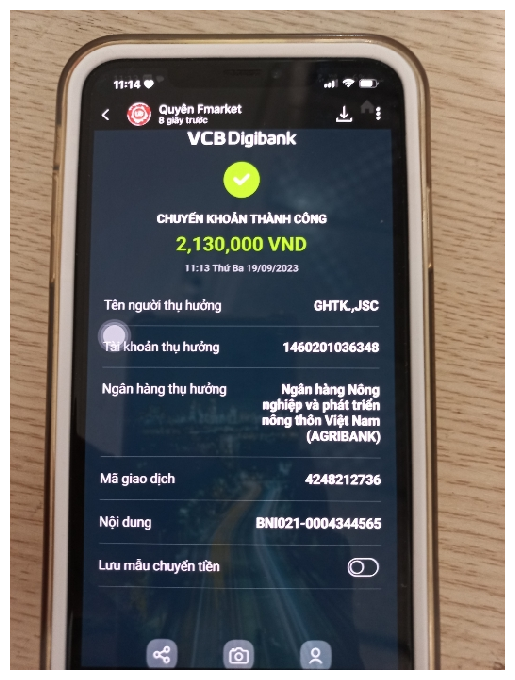

In [48]:
img_url = "/home/fit/optivisionlab/quynh/my_data/yolo_nas/image_test/a.jpg"
best_model.predict(img_url, conf=0.20, fuse_model=False).show()